In [3]:
import os
import librosa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
def folder_to_audio_files(folder_path):
    audio_files = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.endswith('.wav') and os.path.isfile(file_path):
            audio_files.append(file_path)
    return audio_files

# Example usage
source_folder_path = 'Source'  # Replace with the path to your source folder
target_folder_path = 'target'  # Replace with the path to your target folder

source_audio_files = folder_to_audio_files(source_folder_path)
target_audio_files = folder_to_audio_files(target_folder_path)

# Now source_audio_files and target_audio_files contain paths to the audio files in their respective folders

In [6]:
source_audio_files
target_audio_files

['target\\002.wav',
 'target\\005.wav',
 'target\\031.wav',
 'target\\035.wav',
 'target\\1001047364882201153.wav',
 'target\\10014492116422610050.wav',
 'target\\10018188347059055723.wav',
 'target\\10020791949464738657.wav',
 'target\\10025411426812728167.wav',
 'target\\10058821801688040303.wav',
 'target\\10071097508043022696.wav',
 'target\\10097600450430891671.wav',
 'target\\1012326507685528471.wav',
 'target\\10148907792880119076.wav',
 'target\\10160343901636052006.wav',
 'target\\10187025692704313613.wav',
 'target\\10218770658837064427.wav',
 'target\\1057638511207593052.wav',
 'target\\10832986884596224196.wav',
 'target\\219.wav',
 'target\\339.wav',
 'target\\687.wav',
 'target\\763.wav',
 'target\\775.wav',
 'target\\836.wav']

In [7]:
def preprocess_data(wav_files,sr=16000,n_mels=128,seq_len=16):
  """Preprocesses audio data from WAV files for the model.

  Args:
      wav_files: A list of paths to WAV files (source and target).
      sr: Sampling rate (default: 16000 Hz).
      n_mels: Number of mel filterbanks (default: 128).
      seq_len: Maximum sequence length (default: 16).

  Returns:
      source_mels: A NumPy array of preprocessed mel spectrograms for source audio (shape: (num_samples, seq_len, n_mels)).
      target_mels: A NumPy array of preprocessed mel spectrograms for target audio (shape: (num_samples, seq_len, n_mels)).
  """

  source_mels = []
  target_mels = []

  for filename in wav_files:
    # Load audio and extract mel spectrograms
    y,_= librosa.load(filename, sr=sr)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram).astype(np.float32)  # Normalize

    # Pad or trim to fixed sequence length
    if mel_spectrogram.shape[1] > seq_len:
      mel_spectrogram = mel_spectrogram[:,:seq_len]  # Trim if longer
    else:
      pad_width = ((0, 0), (0, seq_len - mel_spectrogram.shape[1]))
      mel_spectrogram = np.pad(mel_spectrogram,pad_width,mode='constant')  # Pad if shorter

    source_mels.append(mel_spectrogram)  # Assuming source and target use the same preprocessed mel spectrograms

  source_mels = np.array(source_mels)
  target_mels = source_mels  # Assuming target audio reconstruction (replace for different target processing)

  return source_mels,target_mels

In [34]:
# Preprocess data
source_mels, target_mels = preprocess_data( source_audio_files+target_audio_files )  # Combine for easier data splitting
# Split data into training, validation, and (if needed) test sets (example using train-test split)
from sklearn.model_selection import train_test_split
train_mels, val_mels, train_targets, val_targets = train_test_split(source_mels, target_mels, test_size=0.2, random_state=42)
#Reshape for model input (add batch dimension)
train_mels = train_mels.reshape((train_mels.shape[0], train_mels.shape[1], train_mels.shape[2], 1))
val_mels = val_mels.reshape((val_mels.shape[0], val_mels.shape[1], val_mels.shape[2], 1))
train_targets = train_targets.reshape((train_targets.shape[0], train_targets.shape[1], train_targets.shape[2], 1))
val_targets = val_targets.reshape((val_targets.shape[0],val_targets.shape[1],val_targets.shape[2],1))

In [26]:
train_mels

array([[[-4.6584579e+01, -4.6584579e+01, -4.6584579e+01, ...,
         -4.6584579e+01, -4.6584579e+01, -4.6584579e+01],
        [-4.6584579e+01, -4.6584579e+01, -4.6584579e+01, ...,
         -4.6584579e+01, -4.6584579e+01, -4.6584579e+01],
        [-4.6584579e+01, -4.6584579e+01, -4.6584579e+01, ...,
         -4.6584579e+01, -4.6584579e+01, -4.6584579e+01],
        ...,
        [-4.6584579e+01, -4.6584579e+01, -4.6584579e+01, ...,
         -4.6584579e+01, -4.6584579e+01, -4.6584579e+01],
        [-4.6584579e+01, -4.6584579e+01, -4.6584579e+01, ...,
         -4.6584579e+01, -4.6584579e+01, -4.6584579e+01],
        [-4.6584579e+01, -4.6584579e+01, -4.6584579e+01, ...,
         -4.6584579e+01, -4.6584579e+01, -4.6584579e+01]],

       [[-7.2882347e+00, -7.4131994e+00, -1.2420363e+01, ...,
         -1.1061775e+01, -9.2673006e+00, -1.1151436e+01],
        [-9.5145206e+00, -9.8026638e+00, -1.5247875e+01, ...,
         -1.1884246e+01, -1.2191467e+01, -1.2536369e+01],
        [-1.2346949e+01, 

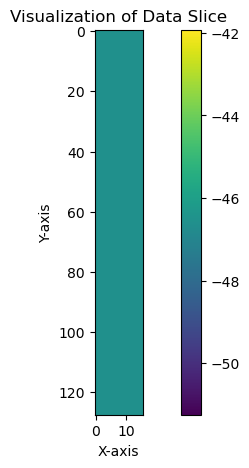

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming your data is stored in a variable called 'data'
# Let's visualize the first slice of the first dimension
slice_to_visualize = train_mels[0,:,:]

# Plotting the slice
plt.figure(figsize=(10, 5))
plt.imshow(slice_to_visualize, cmap='viridis')  # You can change the colormap as per your preference
plt.colorbar()  # Add a colorbar to indicate the scale
plt.title('Visualization of Data Slice')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


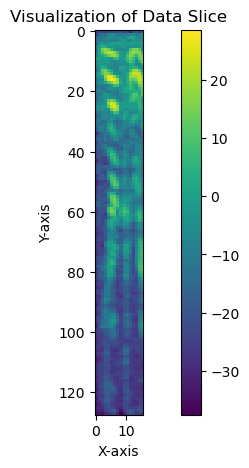

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming your data is stored in a variable called 'data'
# Let's visualize the first slice of the first dimension
slice_to_visualize = val_mels[0,:,:]

# Plotting the slice
plt.figure(figsize=(10, 5))
plt.imshow(slice_to_visualize, cmap='viridis')  # You can change the colormap as per your preference
plt.colorbar()  # Add a colorbar to indicate the scale
plt.title('Visualization of Data Slice')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


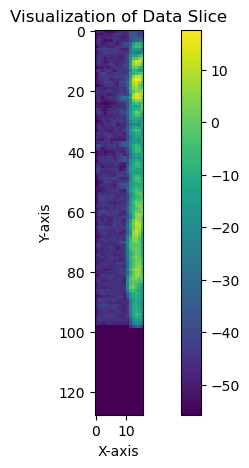

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming your data is stored in a variable called 'data'
# Let's visualize the first slice of the first dimension
slice_to_visualize = target_mels[0,:,:]

# Plotting the slice
plt.figure(figsize=(10, 5))
plt.imshow(slice_to_visualize, cmap='viridis')  # You can change the colormap as per your preference
plt.colorbar()  # Add a colorbar to indicate the scale
plt.title('Visualization of Data Slice')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


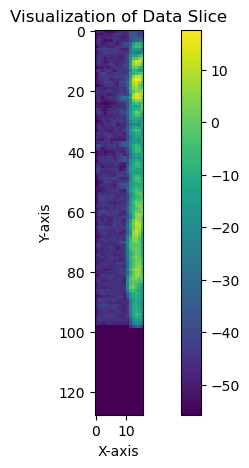

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming your data is stored in a variable called 'data'
# Let's visualize the first slice of the first dimension
slice_to_visualize = target_mels[0,:,:]

# Plotting the slice
plt.figure(figsize=(10, 5))
plt.imshow(slice_to_visualize, cmap='viridis')  # You can change the colormap as per your preference
plt.colorbar()  # Add a colorbar to indicate the scale
plt.title('Visualization of Data Slice')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [31]:
class EncoderDecoder(keras.Model):
    """Encoder-decoder model architecture for audio transformation."""

    def __init__(self, embedding_dim, latent_dim, rnn_units):
        super(EncoderDecoder, self).__init__()

        # Encoder
        self.encoder = keras.Sequential([
            layers.TimeDistributed(layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')),
            layers.TimeDistributed(layers.MaxPooling1D(pool_size=2)),
            layers.LSTM(units=rnn_units, return_sequences=True)
        ])

        # Decoder
        self.decoder = keras.Sequential([
            layers.LSTM(units=rnn_units, return_sequences=True),
            layers.TimeDistributed(layers.Dense(embedding_dim, activation='relu')),
            layers.TimeDistributed(layers.Conv1D(filters=1, kernel_size=3, activation='linear', padding='same'))
        ])

    def call(self, inputs, training=None):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

In [32]:
model = EncoderDecoder(embedding_dim=32, latent_dim=16, rnn_units=128)  # Adjust hyperparameters as needed
model.compile(optimizer='adam', loss='mean_squared_error')  # Choose appropriate optimizer and loss function

In [33]:
history = model.fit(train_mels, train_targets, epochs=100, batch_size=32, validation_data=(val_mels,val_targets))


Epoch 1/100


ValueError: in user code:

    File "C:\Users\User\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\User\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\User\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\User\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\User\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\User\AppData\Local\Temp\__autograph_generated_filezdbfcw15.py", line 10, in tf__call
        encoded = ag__.converted_call(ag__.ld(self).encoder, (ag__.ld(inputs),), None, fscope)

    ValueError: Exception encountered when calling layer 'encoder_decoder_2' (type EncoderDecoder).
    
    in user code:
    
        File "C:\Users\User\AppData\Local\Temp\ipykernel_2800\3000624955.py", line 22, in call  *
            encoded = self.encoder(inputs)
        File "C:\Users\User\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "C:\Users\User\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 253, in assert_input_compatibility
            raise ValueError(
    
        ValueError: Exception encountered when calling layer 'time_distributed_8' (type TimeDistributed).
        
        Input 0 of layer "conv1d_4" is incompatible with the layer: expected min_ndim=3, found ndim=2. Full shape received: (None, 16)
        
        Call arguments received by layer 'time_distributed_8' (type TimeDistributed):
          • inputs=tf.Tensor(shape=(None, 128, 16), dtype=float32)
          • training=True
          • mask=None
    
    
    Call arguments received by layer 'encoder_decoder_2' (type EncoderDecoder):
      • inputs=tf.Tensor(shape=(None, 128, 16), dtype=float32)
      • training=True
